# Spotify Music Recommendation System with Mood Detection Using The Million Song Dataset

Author: James Meredith

Instructor: David Elliot

Institution: Flatiron School

Active Project Dates: Jun 267th, 2023 - July 14th, 2023

## Overview

Recommendation systems use machine learning to solve the long-tail problem with digital content. There is a lot of content out on the internet so it would take a person a long time to sort through it to find something they like. Recommendation systems help wth that buy suggesting content to people. [Netflix estimates](https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48) it gets around 80% of total watch time thanks to its recommendation system.

The data is fairly clean already so most of the preperation involved manipulating the datasets into formats that can be used by recommendation systems, some recommendation systems use the format provided but ALS by hand and cosign similarity required some modifications.

Our modeling approach was:

- Start with a content-based system using cosign similarity, a commonly used distance measurement for recommendation systems
- Move to collaborative filtering using surprise, the popular library for implementing predictive recommendation systems
- Introduce ALS by hand to cement our understanding of the approach
- Implement ALS in Spark using pyspark separately, spark is commonly used to implement ALS at scale

We evaluated these models using RMSE as the measurement. Netflix's famous competition that offered $1M to a winner that could improve their content recommendation algorythm by 10% RMSE which was finally won by BellKor’s Pragmatic Chaos in 2009 with an RMSE of 0.8567. We decided that was our goal. All models were trained on train data, cross validated, and then evaluated on test data.

Note: ratings were on a scale of 1-5 so a RMSE of 1 means the average prediction was off by a whole score

Our best performing model was SVD optimized using gridsearch using surprise. Our recommendation however is to use ALS via spark to start however because of the efficiency of ALS and Spark in handling large datasets.

## Business Problem

## The Data

The dataset used for this project was the Million Song Database. It contains metadata for one million songs. The metadata includes information such as artist, title, year, and genre. The dataset also contains audio features for each song. The audio features are extracted from the audio files using the Echo Nest analyzer. The audio features include information such as tempo, loudness, and key. The dataset also contains lyrics for each song. The lyrics are extracted from the audio files using the Musixmatch analyzer. The lyrics are stored as a bag of words. The dataset is stored in HDF5 format. The dataset is 280 GB uncompressed. The dataset is available for download at http://millionsongdataset.com/. The dataset is also available on AWS S3 at s3://millionsongdataset/. 

The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. The Million Song Dataset started as a collaborative project between The Echo Nest and LabROSA. It was supported in part by the NSF. 

Its purposes are:

- To encourage research on algorithms that scale to commercial sizes
- To provide a reference dataset for evaluating research
- As a shortcut alternative to creating a large dataset with APIs (e.g. The Echo Nest's)
- To help new researchers get started in the MIR field

The core of the dataset is the feature analysis and metadata for one million songs, provided by The Echo Nest. 

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. 
The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011.

### Exploring The Dataset

In [47]:
# Imports Required for Accessing the Data
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd
import tables as tb
import sqlite3
import json

# Imports Required for the Mood Detection System

# Imports Required for the Recommender System
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

The structure of the dataset is quite complex, with many nested folders with files within them. The first step is to explore the structure of the dataset. Here we use the os module to explore the structure of the dataset.

In [48]:
# Establishes path to the Million Song Dataset subset
msd_subset_path='./data/MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')

# Establishes path to the Million Song Dataset code
msd_code_path='./code/MSongsDB'
assert os.path .isdir(msd_code_path),'wrong path' # sanity check
# we add some paths to python so we can import MSD code
# Ubuntu: you can change the environment variable PYTHONPATH
# in your .bashrc file so you do not have to type these lines
sys.path.append( os.path.join(msd_code_path,'PythonSrc') )

# Imports the MSD Python code
import hdf5_getters as GETTERS

# Establish path to the Last.fm dataset
lastfm_subset_path = './data/lastfm_subset'

# Creates a function to display the folder structure of the dataset
def display_folder_structure(path, indent='', max_depth=float('inf'), depth=0):
    if depth > max_depth:
        return

    files = os.listdir(path)
    for file in files:
        current_path = os.path.join(path, file)
        if os.path.isdir(current_path):
            print(f"{indent}|- {file}/")
            display_folder_structure(current_path, indent + '  ', max_depth, depth + 1)
        else:
            print(f"{indent}|- {file}")


# Uses the function to display the folder structure of the dataset to the specified depth
max_display_depth = 0  # Specify the maximum depth to display
display_folder_structure(msd_subset_path, max_depth=max_display_depth)

|- A/
|- B/


So the structure of the dataset is as follows:

- The dataset is stored in the folder `MillionSongSubset`
- The individual dataset files are stored in HDF5 format
- The dataset is stored in a nested folder structure
- The dataset contains 10,000 folders, each containing 100 folders, each containing 100 files

The next step is to explore the contents of the dataset. Here we use the h5py module to explore the contents of the dataset.


In [49]:
# Let's open one file and explore it's structure and contents
h5file_path = '.\data\MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5'
h5file = tb.open_file(h5file_path, mode='r')
h5file 

File(filename=.\data\MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5, title='H5 Song File', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'H5 Song File'
/analysis (Group) 'Echo Nest analysis of the song'
/analysis/bars_confidence (EArray(83,)shuffle, zlib(1)) 'array of confidence of bars'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/bars_start (EArray(83,)shuffle, zlib(1)) 'array of start times of bars'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/beats_confidence (EArray(344,)shuffle, zlib(1)) 'array of confidence of sections'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1024,)
/analysis/beats_start (EArray(344,)shuffle, z

In [50]:
h5file.root

/ (RootGroup) 'H5 Song File'
  children := ['analysis' (Group), 'metadata' (Group), 'musicbrainz' (Group)]

In [51]:
h5file.root.analysis


/analysis (Group) 'Echo Nest analysis of the song'
  children := ['bars_confidence' (EArray), 'bars_start' (EArray), 'beats_confidence' (EArray), 'beats_start' (EArray), 'sections_confidence' (EArray), 'sections_start' (EArray), 'segments_confidence' (EArray), 'segments_loudness_max' (EArray), 'segments_loudness_max_time' (EArray), 'segments_loudness_start' (EArray), 'segments_pitches' (EArray), 'segments_start' (EArray), 'segments_timbre' (EArray), 'songs' (Table), 'tatums_confidence' (EArray), 'tatums_start' (EArray)]

In [52]:
h5file.root.metadata

/metadata (Group) 'metadata about the song'
  children := ['artist_terms' (EArray), 'artist_terms_freq' (EArray), 'artist_terms_weight' (EArray), 'similar_artists' (EArray), 'songs' (Table)]

In [53]:
h5file.root.musicbrainz

/musicbrainz (Group) 'data about the song coming from MusicBrainz'
  children := ['artist_mbtags' (EArray), 'artist_mbtags_count' (EArray), 'songs' (Table)]

So the structure of each .h5 file is as follows:
- The file contains 3 groups: analysis, metadata, and musicbrainz
- The analysis group contains:
    bars_confidence, bars_start, beats_confidence, beats_start, sections_confidence, sections_start, segments_confidence, segments_loudness_max, segments_loudness_max_time, segments_loudness_start, segments_pitches, segments_start, segments_timbre, songs, tatums_confidence, and tatums_start
- The metadata group contains:
    artist_terms, artist_terms_freq, artist_terms_weight, similar_artists, songs, and tags
- The musicbrainz group contains:
    artist_mbtags, artist_mbtags_count, songs, and tags


### Additional Datasets

#### The Last.fm Dataset

#### The Echo Nest Taste Profile Subset

## Data Preperation & Cleaning

Because the structure of the dataset is catered towards big data applications, it is not ideal for machine learning applications. The first step is to convert the dataset into a more machine learning friendly format. Here we use the pandas module to convert the dataset into a pandas dataframe.

In [54]:
h5file_exploratory_df = pd.DataFrame(h5file)
h5file_exploratory_df

,0,1,2,3,4,5,6,7,8,9,...,961,962,963,964,965,966,967,968,969,970
0,/analysis (Group) 'Echo Nest analysis of the s...,/metadata (Group) 'metadata about the song',/musicbrainz (Group) 'data about the song comi...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"/analysis/bars_confidence (EArray(83,)shuffle,...","/analysis/bars_start (EArray(83,)shuffle, zlib...","/analysis/beats_confidence (EArray(344,)shuffl...","/analysis/beats_start (EArray(344,)shuffle, zl...","/analysis/sections_confidence (EArray(10,)shuf...","/analysis/sections_start (EArray(10,)shuffle, ...","/analysis/segments_confidence (EArray(971,)shu...","/analysis/segments_loudness_max (EArray(971,)s...",/analysis/segments_loudness_max_time (EArray(9...,"/analysis/segments_loudness_start (EArray(971,...",...,None,None,None,None,None,None,None,None,None,None
2,"/metadata/artist_terms (EArray(37,)shuffle, zl...","/metadata/artist_terms_freq (EArray(37,)shuffl...","/metadata/artist_terms_weight (EArray(37,)shuf...","/metadata/similar_artists (EArray(100,)shuffle...","[/metadata/songs.row (Row), pointing to row #0]",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"/musicbrainz/artist_mbtags (EArray(0,)shuffle,...","/musicbrainz/artist_mbtags_count (EArray(0,)sh...","[/musicbrainz/songs.row (Row), pointing to row...",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0.643,0.746,0.722,0.095,0.091,0.362,0.465,0.204,0.129,0.618,...,None,None,None,None,None,None,None,None,None,None
5,0.58521,2.94247,5.14371,7.74554,10.36149,12.98399,15.59835,18.21002,20.81724,23.41491,...,None,None,None,None,None,None,None,None,None,None
6,0.834,0.851,0.65,0.635,0.532,0.753,0.622,0.657,0.704,0.745,...,None,None,None,None,None,None,None,None,None,None
7,0.58521,1.19196,1.78893,2.37813,2.94247,3.50622,4.05077,4.56902,5.14371,5.76504,...,None,None,None,None,None,None,None,None,None,None
8,1.0,1.0,0.218,0.133,0.384,0.326,0.373,0.129,0.588,0.62,...,None,None,None,None,None,None,None,None,None,None
9,0.0,7.74554,36.44331,43.61667,75.17954,90.1827,135.77195,164.23964,189.03133,198.20273,...,None,None,None,None,None,None,None,None,None,None


In [55]:
h5file_exploratory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Columns: 971 entries, 0 to 970
dtypes: object(971)
memory usage: 212.5+ KB


Attempting to import an individual data file wholesale into a pandas dataframe results in a dataframe with 971 columns and 27 rows - for just one song! Multiply that by 10,000 for the number of songs in the dataset and you have a dataframe with 9,710,000 columns and 270,000 rows - for just the Million Song Subset! This is not ideal for loading into memory on a local machine. Instead we will only load the columns we need into the dataframe moving forward. We'll start by defining a function that can iterate through the dataset and load the columns we need into a dataframe, and then prepare the dataframe for machine learning applications.

In [56]:
# we define this very useful function to iterate through all the files in the dataset
def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    """
    From a base directory, go through all subdirectories,
    find all files with the given extension, apply the
    given function 'func' to all of them.
    If no 'func' is passed, we do nothing except counting.
    INPUT
       basedir  - base directory of the dataset
       func     - function to apply to all filenames
       ext      - extension, .h5 by default
    RETURN
       number of files
    """
    cnt = 0
    # iterate over all files in all subdirectories
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        # count files
        cnt += len(files)
        # apply function to all files
        for f in files :
            func(f)       
    return cnt

In [57]:
# we can now easily count the number of files in the dataset
print('number of song files:',apply_to_all_files(msd_subset_path))

number of song files: 10000


In [58]:
msd_df = pd.DataFrame()

In [59]:
# Creates a function to open a file and return the data
def get_data(filename):
    # Opens the file
    get_data_file = GETTERS.open_h5_file_read(filename)
    # Append the track id to the dataframe as the index
    msd_df.loc[filename, 'track_id'] = GETTERS.get_track_id(get_data_file).decode('utf-8')
    # Append the song name to the dataframe
    msd_df.loc[filename, 'title'] = GETTERS.get_title(get_data_file).decode('utf-8')
    # Append the artist ID to the dataframe
    msd_df.loc[filename, 'artist_id'] = GETTERS.get_artist_id(get_data_file).decode('utf-8')
    # Append the artist name to the dataframe
    msd_df.loc[filename, 'artist_name'] = GETTERS.get_artist_name(get_data_file).decode('utf-8')
    # Append the release to the dataframe
    msd_df.loc[filename, 'release'] = GETTERS.get_release(get_data_file).decode('utf-8')
    # Appends the song year to the dataframe - omitted due to lack of data
    # df.loc[filename, 'year'] = GETTERS.get_year(get_data_file)
    # Appends the song mode to the dataframe
    msd_df.loc[filename, 'mode'] = GETTERS.get_mode(get_data_file)
    # Appends the song time signature to the dataframe
    msd_df.loc[filename, 'time_signature'] = GETTERS.get_time_signature(get_data_file)
    # Appends the song tempo to the dataframe
    msd_df.loc[filename, 'tempo'] = GETTERS.get_tempo(get_data_file)
    # Appends the song loudness to the dataframeq
    msd_df.loc[filename, 'loudness'] = GETTERS.get_loudness(get_data_file)
    # # Appends the song energy to the dataframe - omitted due to lack of data
    # df.loc[filename, 'energy'] = GETTERS.get_energy(get_data_file)
    # # Appends the song danceability to the dataframe - omitted due to lack of data
    # df.loc[filename, 'danceability'] = GETTERS.get_danceability(get_data_file) 
    # Appends the popularity to the dataframe
    # df.loc[filename, 'song_hotttnesss'] = GETTERS.get_song_hotttnesss(get_data_file)
    #closes the file
    get_data_file.close()

In [60]:
# Applies the function to all files in the dataset
apply_to_all_files(msd_subset_path, func=get_data)

10000

In [61]:
msd_df.head()

,track_id,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness
./data/MillionSongSubset\A\A\A\TRAAAAW128F429D538.h5,TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197
./data/MillionSongSubset\A\A\A\TRAAABD128F429CF47.h5,TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843
./data/MillionSongSubset\A\A\A\TRAAADZ128F9348C2E.h5,TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689
./data/MillionSongSubset\A\A\A\TRAAAEF128F4273421.h5,TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013
./data/MillionSongSubset\A\A\A\TRAAAFD128F92F423A.h5,TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501


In [62]:
# Sets the index to the song ID
msd_df = msd_df.set_index('track_id').rename_axis(None)

In [64]:
msd_df.head()

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501


In [65]:
msd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           10000 non-null  object 
 1   artist_id       10000 non-null  object 
 2   artist_name     10000 non-null  object 
 3   release         10000 non-null  object 
 4   mode            10000 non-null  float64
 5   time_signature  10000 non-null  float64
 6   tempo           10000 non-null  float64
 7   loudness        10000 non-null  float64
dtypes: float64(4), object(4)
memory usage: 703.1+ KB


In [84]:
# Creates a dummy variable for each release without the "release_" prefix
msd_df = pd.concat([msd_df, pd.get_dummies(msd_df['release'])], axis=1)
msd_df = msd_df.drop('release', axis=1)

In [85]:
msd_df.head()

,title,artist_id,artist_name,mode,time_signature,tempo,loudness,Lazy Afternoon En Anglais,#8,&Like A Bolt Of Lightning,...,tiefblau,¡Dundunbanza!,¡La Rumba está buena!,¿Qué Pasa?: The Best Of The Fania All-Stars,À table (Chansons bleues ou à poing),Äio,Ärger Mit Der Unsterblichkeit,Étnico Ma Non Troppo,Über alles in der Welt / Ihr hated nur (Remix),Überfall
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,0.0,4.0,92.198,-11.197,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,0.0,4.0,121.274,-9.843,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,1.0,1.0,100.070,-9.689,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,1.0,4.0,119.293,-9.013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,1.0,4.0,129.738,-4.501,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
msd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Columns: 15675 entries, title to Überfall
dtypes: float64(4), object(3), uint8(15668)
memory usage: 150.3+ MB


In [64]:
# Opens lastfm_tags.db and creates a connection
conn = sqlite3.connect('./data/lastfm_tags.db')
# Execute the SQL query and fetch the results into a DataFrame
query = '''
SELECT tids.tid, GROUP_CONCAT(tags.tag) AS tags FROM tid_tag
        INNER JOIN tids ON tids.ROWID=tid_tag.tid
        INNER JOIN tags ON tags.ROWID=tid_tag.tag
		GROUP BY tid_tag.tid
        '''
results = pd.read_sql_query(query, conn)
# Closes the connection
conn.close()

In [65]:
results.head()

,tid,tags
0,TRCCCYE12903CFF0E9,"classic rock,Progressive rock"
1,TRCCCFH12903CEBC70,"blues,memphis slim"
2,TRCCCJT128F429FFF6,"pop,70s,Middle of the road,Bonjour ca va"
3,TRCCCBJ128F4286E6F,"Tony Levin,instrumental,Zappa Related,Bozzio L..."
4,TRCCJTI128EF35394A,Czech


In [76]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505216 entries, 0 to 505215
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tid     505216 non-null  object
 1   tags    505216 non-null  object
dtypes: object(2)
memory usage: 7.7+ MB


In [77]:
# concatenates the two dataframes on the track ID
df_final = pd.concat([df, results.set_index('tid')], axis=1, join='inner')

In [78]:
df_final.head()

,title,artist_id,artist_name,release,year,mode,time_signature,tempo,loudness,tags
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,0.0,4.0,92.198,-11.197,"Hip-Hop,classic,heard on Pandora,stream,Bay Ar..."
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,1969.0,0.0,4.0,121.274,-9.843,"classic rock,pop,beautiful,rock,soul,Love,male..."
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,0.0,1.0,1.0,100.070,-9.689,latin
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1982.0,1.0,4.0,119.293,-9.013,"80s,new wave,freedom,strangeromanticdeadrockcave"
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,2007.0,1.0,4.0,129.738,-4.501,"punk rock,punk"


In [79]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4833 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           4833 non-null   object 
 1   artist_id       4833 non-null   object 
 2   artist_name     4833 non-null   object 
 3   release         4833 non-null   object 
 4   year            4833 non-null   float64
 5   mode            4833 non-null   float64
 6   time_signature  4833 non-null   float64
 7   tempo           4833 non-null   float64
 8   loudness        4833 non-null   float64
 9   tags            4833 non-null   object 
dtypes: float64(5), object(5)
memory usage: 415.3+ KB


In [71]:
# creates a dummy variable for each tag
df_final = pd.concat([df_final, df_final['tags'].str.get_dummies(sep=',')], axis=1)

In [72]:
df_final.head()

,title,artist_id,artist_name,release,year,mode,time_signature,tempo,loudness,tags,...,zwischenstation,zwischenzeit,zwoar,zwoel,zydeco,zyrotechira,zywe,zz96jd,zzz,zzzzzzzzzzzzzzz
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,0.0,4.0,92.198,-11.197,"Hip-Hop,classic,heard on Pandora,stream,Bay Ar...",...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,1969.0,0.0,4.0,121.274,-9.843,"classic rock,pop,beautiful,rock,soul,Love,male...",...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,0.0,1.0,1.0,100.070,-9.689,latin,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1982.0,1.0,4.0,119.293,-9.013,"80s,new wave,freedom,strangeromanticdeadrockcave",...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,2007.0,1.0,4.0,129.738,-4.501,"punk rock,punk",...,0,0,0,0,0,0,0,0,0,0


In [74]:
df_final

,title,artist_id,artist_name,release,year,mode,time_signature,tempo,loudness,tags,...,zwischenstation,zwischenzeit,zwoar,zwoel,zydeco,zyrotechira,zywe,zz96jd,zzz,zzzzzzzzzzzzzzz
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,0.0,4.0,92.198,-11.197,"Hip-Hop,classic,heard on Pandora,stream,Bay Ar...",...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,1969.0,0.0,4.0,121.274,-9.843,"classic rock,pop,beautiful,rock,soul,Love,male...",...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,0.0,1.0,1.0,100.070,-9.689,latin,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1982.0,1.0,4.0,119.293,-9.013,"80s,new wave,freedom,strangeromanticdeadrockcave",...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,2007.0,1.0,4.0,129.738,-4.501,"punk rock,punk",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBIJLT12903CE7070,God Don't Never Change,ARDK0551187FB5AC48,Blind Willie Johnson,Praise God I'm Satisfied,1989.0,1.0,1.0,95.677,-16.159,"blues,gospel,loved,singer-songwriter,friendsof...",...,0,0,0,0,0,0,0,0,0,0
TRBIJMU12903CF892B,The Hanged Man,AR4C6V01187FB3BAF4,Moonspell,Sin / Pecado,1998.0,1.0,4.0,140.185,-8.087,"beautiful,best,sad,nice,acoustic,melancholic,r...",...,0,0,0,0,0,0,0,0,0,0
TRBIJNF128F14815A7,The Wonderful World Of The Young,AR9JLBU1187B9AAEC4,Danny Williams,Collection,1998.0,1.0,3.0,77.072,-14.517,"oldies,feelings",...,0,0,0,0,0,0,0,0,0,0
TRBIJRN128F425F3DD,Zydeco In D-Minor,ARAGMIV11F4C843F78,"Myrick ""Freeze"" Guillory",Nouveau Zydeco,0.0,1.0,4.0,137.663,-12.574,"zydeco,novea zydeco",...,0,0,0,0,1,0,0,0,0,0


#### Last.Fm Dataset

In [110]:
# Creates an empty dataframe with track_id and tags columns
lastfm_tags_df = pd.DataFrame(columns=['tags'])

In [111]:
def get_tags(file_path):
    # Load the JSON data from the file
    with open(file_path) as f:
        lastfm_file = json.load(f)

    # Extract only the 'tag_name' values from the 'tags' list
    tags = [tag[0] for tag in lastfm_file['tags']]
    # Turns the tags into a string separated by commas
    tags = ', '.join(tags)

    # Appends the tags to the dataframe
    lastfm_tags_df.loc[lastfm_file['track_id'], 'tags'] = tags

In [112]:
apply_to_all_files(lastfm_subset_path, func=get_tags, ext='.json')

9330

In [113]:
lastfm_tags_df.head()

,tags
TRAAAAW128F429D538,"Bay Area, hieroglyiphics, classic, Hip-Hop, st..."
TRAAABD128F429CF47,"60s, soul, pop, rock, male vocalists, oldies, ..."
TRAAADZ128F9348C2E,latin
TRAAAEF128F4273421,"new wave, 80s, freedom, strangeromanticdeadroc..."
TRAAAFD128F92F423A,"punk rock, punk"


In [122]:
import nltk
from nltk.corpus import wordnet

# Retrieve synonyms for the word "angry"
synonyms = []
for syn in wordnet.synsets("angry"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())

# Add the synonyms to the filter
filter_keywords = ['angry'] + synonyms

# Filters the dataframe to only include songs with the filter keywords
angry_df = lastfm_tags_df[lastfm_tags_df['tags'].str.contains('|'.join(filter_keywords))]
# Creates a column for the emotion
angry_df['emotion'] = 'angry'



C:\Users\James\AppData\Local\Temp\ipykernel_23648\1486403377.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angry_df['emotion'] = 'angry'


In [123]:
angry_df

,tags,emotion
TRAAOJI128F1458DCD,"80s, new wave, synthpop, electronic, synth pop...",angry
TRAASKQ128F4265E04,"cover, rock, alternative rock, metal, Rage Aga...",angry
TRABJIX128C7196953,"soul, jazz, female vocalists, british, Amy Win...",angry
TRABZOP128F9316E24,"indie, rock, indie rock, alternative, franz fe...",angry
TRACBWP128C7196948,"rock, alternative rock, 3 Doors Down, alternat...",angry
...,...,...
TRBGCAK128F425F3CC,"electronic, techno, dance, electronica, indust...",angry
TRBGJDW128F4292EDB,"rnb, soul, Alicia Keys, female vocalists, Karm...",angry
TRBGNPE128E078EC14,"rap, Hip-Hop, Eminem, hip hop, just dont give ...",angry
TRBHKKK128F427E9FF,"rock, alternative rock, alternative, 3 Doors D...",angry


In [124]:
# Retrieve synonyms for the word "happy"
synonyms = []
for syn in wordnet.synsets("happy"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())
# Add the synonyms to the filter
filter_keywords = ['happy'] + synonyms
# Filters the dataframe to only include songs with the filter keywords
happy_df = lastfm_tags_df[lastfm_tags_df['tags'].str.contains('|'.join(filter_keywords))]
# Creates a column for the emotion
happy_df['emotion'] = 'happy'

C:\Users\James\AppData\Local\Temp\ipykernel_23648\3849455606.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happy_df['emotion'] = 'happy'


In [125]:
happy_df

,tags,emotion
TRAACNS128F14A2DF5,"latin, jazz, latin jazz, Soundtrack, Latin-jaz...",happy
TRAADQX128F422B4CF,"Lo-Fi, indie, indietronica, electronic, 8-bit,...",happy
TRAAGCZ128F93210FD,"Hip-Hop, dance, pop, hip hop, black eyed peas,...",happy
TRAAKDG128F42A0ECB,"dance, pop, latin, Shakira, sexy, hot, catchy,...",happy
TRAAPPQ128F14961F5,"new wave, pop, 1987, american, 80s, eclectonia...",happy
...,...,...
TRBHVLH128F92F2369,"singer-songwriter, female vocalists, pop, indi...",happy
TRBIAHA128F42A4C9B,"80s, post-punk, new wave, punk, alternative, P...",happy
TRBIBTE128E078E882,"mod, 80s, new wave, british, rock, punk, mod r...",happy
TRBIFGK128F92F23A2,"indie rock, indie, rock, alternative rock, alt...",happy


In [126]:
# Retrieve synonyms for the word "sad"
synonyms = []
for syn in wordnet.synsets("sad"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())

# Add the synonyms to the filter
filter_keywords = ['sad'] + synonyms
# Filters the dataframe to only include songs with the filter keywords
sad_df = lastfm_tags_df[lastfm_tags_df['tags'].str.contains('|'.join(filter_keywords))]
# Creates a column for the emotion
sad_df['emotion'] = 'sad'

C:\Users\James\AppData\Local\Temp\ipykernel_23648\4247122276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sad_df['emotion'] = 'sad'


In [127]:
sad_df

,tags,emotion
TRAADLN128F14832E9,"classic rock, rock, 70s, the rolling stones, B...",sad
TRAAEWG128F930B3A4,"indie rock, indie, kings of leon, rock, Garage...",sad
TRAAFMS128F933AB23,"Rock Argentino, rock, Rock en Espanol, 90s, Ro...",sad
TRAAGEC128E079252C,"industrial, cover, industrial rock, electronic...",sad
TRAAGJV128F1464090,"60s, oldies, pop, female vocalists, rock n rol...",sad
...,...,...
TRBICGT128E0792473,"rock, hard rock, classic rock, 80s, Guns N Ros...",sad
TRBICVB128F9326B65,"alternative rock, emo, MOONH8SUN, Eric Victori...",sad
TRBIFGK128F92F23A2,"indie rock, indie, rock, alternative rock, alt...",sad
TRBIGRY128F42597B3,"soul, Sade, female vocalists, jazz, chillout, ...",sad


In [128]:
# Retrieve synonyms for the word "calm"
synonyms = []
for syn in wordnet.synsets("calm"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())

# Add the synonyms to the filter
filter_keywords = ['calm'] + synonyms

# Filters the dataframe to only include songs with the filter keywords
calm_df = lastfm_tags_df[lastfm_tags_df['tags'].str.contains('|'.join(filter_keywords))]
# Creates a column for the emotion
calm_df['emotion'] = 'calm'


C:\Users\James\AppData\Local\Temp\ipykernel_23648\1207863983.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calm_df['emotion'] = 'calm'


In [129]:
calm_df

,tags,emotion
TRAACER128F4290F96,"mathcore, hardcore, experimental, metalcore, m...",calm
TRAACFV128F935E50B,"oldies, 60s girls, female vocalist, memories, ...",calm
TRAAGPH128F4273C8D,"savage garden, pop, australian, amazing, Guilt...",calm
TRAAGPJ128F428CD1B,"Stoner Rock, rock, alternative rock, alternati...",calm
TRAAIHL128F92E6DDA,"rnb, slow jams, 90s, soul, love songs, Love, p...",calm
...,...,...
TRBHWUC128E0784FF1,"piano, Piano - quiet, Love, ambient, instrumen...",calm
TRBHXUG128EF343575,"soul, gospel, female vocalists, black gospel, ...",calm
TRBICQR128F9322603,"EPMD, Erick Sermon, mitchy slick, Strong arm s...",calm
TRBIFUV12903D07374,"soul, female vocalists, 70s, Love, romantic, o...",calm


In [78]:
# Creates a dummy variable for each tag
lastfm_tags_df = pd.concat([lastfm_tags_df, lastfm_tags_df['tags'].str.get_dummies(sep=',')], axis=1)
# Drops the tags column from the dataframe
lastfm_tags_df.drop('tags', axis=1, inplace=True)

In [79]:
lastfm_tags_df.head()

,#1,'00s,'60s,*nsync,-,---,---03fh,---04fh,---11fh,---17fh,...,xmas,xmasparty,ye-ye,yeah,yes,yes no maybe,yessss,you,zouk,zydeco
TRAAAAW128F429D538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
lastfm_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9330 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Columns: 34220 entries,  #1 to zydeco
dtypes: int64(34220)
memory usage: 2.4+ GB


In [81]:
# merges the two dataframes on the index
merged_df = pd.merge(msd_df, lastfm_tags_df, left_index=True, right_index=True)

In [82]:
merged_df.head()

,title,artist_id,artist_name,release,mode,time_signature,tempo,loudness,Lazy Afternoon En Anglais,#8,...,xmas,xmasparty,ye-ye,yeah,yes,yes no maybe,yessss,you,zouk,zydeco
TRAAAAW128F429D538,I Didn't Mean To,ARD7TVE1187B99BFB1,Casual,Fear Itself,0.0,4.0,92.198,-11.197,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,Soul Deep,ARMJAGH1187FB546F3,The Box Tops,Dimensions,0.0,4.0,121.274,-9.843,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,Amor De Cabaret,ARKRRTF1187B9984DA,Sonora Santanera,Las Numero 1 De La Sonora Santanera,1.0,1.0,100.070,-9.689,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,Something Girls,AR7G5I41187FB4CE6C,Adam Ant,Friend Or Foe,1.0,4.0,119.293,-9.013,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,Face the Ashes,ARXR32B1187FB57099,Gob,Muertos Vivos,1.0,4.0,129.738,-4.501,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9330 entries, TRAAAAW128F429D538 to TRBIJYB128F14AE326
Columns: 42062 entries, title to zydeco
dtypes: float64(4), int64(34220), object(4), uint8(7834)
memory usage: 2.4+ GB


## Creating the Mood Detection Model

Here is outlined the creation of the mood detection model. The mood detection model is a multi-class classification model that predicts the mood of a song based on its audio features. The purpose of the model is to automatically tag songs in the database to allow for easy filtering based on mood. The songs appropriate for a user's mood are then used to create a recommendation list for the user, and those that are inappropriate are excluded.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification

In [109]:
import nltk
from nltk.corpus import wordnet

# Retrieve synonyms for the word "angry"
synonyms = []
for syn in wordnet.synsets("angry"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())

# Add the synonyms to the filter
filter_keywords = ['angry'] + synonyms

# Convert columns to strings
merged_df = merged_df.astype(str)

# Filter the DataFrame using the updated filter keywords
filter_condition = merged_df[merged_df.filter(like=filter_keywords[0]).any(axis=1)]
for keyword in filter_keywords[1:]:
    filter_condition = filter_condition | merged_df[merged_df.filter(like=keyword).any(axis=1)]

angry_df = merged_df[filter_condition]


KeyboardInterrupt: 

In [103]:
angry_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, TRAAOJI128F1458DCD to TRBHLBZ128F9300586
Columns: 42058 entries, mode to zydeco
dtypes: float64(4), int64(34220), uint8(7834)
memory usage: 14.2+ MB


In [ ]:
# Views the balance of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
df['mood'].value_counts(normalize=True).sort_index()

0    0.246622
1    0.260698
2    0.243243
3    0.249437
Name: mood, dtype: float64

**Discussion: The data at a glance**
- We can note that the initial balance of each mood class is quite good as we have a good amount of data for each mood

**Limitations of the data:**
- We're using a dataset that uses audio feature metrics created by Spotify in their API. This is a limitation because it's somewhat opaque how each audio feature is calculated, and it's possible that the audio features are not representative of the actual audio features of the song. This project assumes that the audio features are accurate and representative of the actual audio features of the song.
- We're using user-generated tags from Last.FM to determine the dominant mood of a song. This is a limitation because it's possible that the tags are not accurate, or that the tags are not representative of the dominant mood of the song. This project assumes that the tags are accurate and representative of the dominant mood of the song.


### Data Preparation

Songs were tagged with one of 4 moods: happy, sad, angry, and calm. All columns containing non-numeric data unessential to training the model were dropped. The dataset contained no nulls. The data was then split into a training set and a test set, with the training set containing 80% of the data, and the test set containing 20% of the data. The training set was used to train the model, and the test set was used to test the model. The data was then used to train a machine learning algorithm in order to build the detection model.

In [ ]:
# Creates of list of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
mood_list = ['Happy', 'Angry', 'Sad', 'Relaxed']

In [ ]:
# Preparing columns to drop out of X
columns_to_drop=df.columns[0:6].tolist()
columns_to_drop.append(df.columns[-2])
columns_to_drop.append(df.columns[-1])

### Performing the Initial Train-Test Split

In [ ]:
# Splits the dataset into training and testing sets
X = df.drop(columns_to_drop, axis=1)  # Features
y = df['mood']  # Emotion labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Further split the entire dataset into holdout set and evaluation set
X_holdout, X_eval, y_holdout, y_eval = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
X

,tempo,energy,danceability,loudness,valence,acousticness
0,126.366,0.667,0.382,-16.077,0.718,0.000652
1,145.035,0.760,0.405,-4.852,0.316,0.008240
2,144.585,0.703,0.574,-7.789,0.275,0.006580
3,118.181,0.925,0.600,-9.148,0.382,0.008820
4,132.145,0.823,0.622,-5.381,0.605,0.094600
...,...,...,...,...,...,...
1771,136.924,0.286,0.434,-10.803,0.122,0.533000
1772,137.928,0.605,0.536,-6.231,0.156,0.129000
1773,122.979,0.137,0.424,-15.580,0.288,0.909000
1774,190.714,0.285,0.326,-9.377,0.455,0.841000


In [ ]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1771    3
1772    3
1773    3
1774    3
1775    3
Name: mood, Length: 1776, dtype: int64

### Data Modeling

The detection model was created using an iterative approach that compared the accuracy and efficiency of several different machine learning models against a baseline dummy model. Pipelines were used to efficiently process the data for each model. The models were then tuned using GridSearchCV to find the optimal hyperparameters for each model. The models were then evaluated using accuracy scores and confusion matrices.

#### Creating Pipeline to Prepare for Modeling

In [ ]:
# Creating Pipelines
subpipe_numerics = Pipeline(steps = [
	('ss', StandardScaler())
])

In [ ]:
# Creating a Column Transformer
CT = ColumnTransformer(transformers=[
	('subpipe_numerics', subpipe_numerics,selector(dtype_include=np.number))
], remainder='passthrough')

#### Creating the Baseline Dummy Model

In [ ]:
# Creates a Pipeline for the Dummy Baseline Model
dummy_model_pipe = Pipeline(steps = [
	('ct',CT),
	('baseline', DummyClassifier(strategy='most_frequent'))
])

In [ ]:
# Trains the model on the training data
dummy_model_pipe.fit(X_train, y_train)  

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                ('baseline', DummyClassifier(strategy='most_frequent'))])

In [ ]:
# Returns the mean accuracy score of the model based on the given training data and labels
dummy_model_pipe.score(X_train, y_train)

0.2549295774647887

In [ ]:
# Returns the mean accuracy score of the model based on the given testing data and labels
dummy_model_pipe.score(X_test, y_test)

0.28370786516853935

In [ ]:
# Creating a custom function to calculate the accuracy score of the model
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

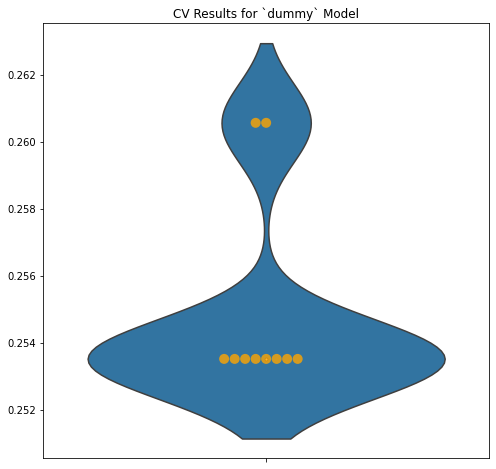

In [ ]:
# Creates a Cross-validated accuracy graph for the Dummy Baseline Model
dummy_pipe = ModelWithCV(
	dummy_model_pipe,
	model_name='dummy',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

dummy_pipe.plot_cv(ax=ax);

Accuracy: 0.28370786516853935
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.28      1.00      0.44       101
           2       0.00      0.00      0.00        76
           3       0.00      0.00      0.00        96

    accuracy                           0.28       356
   macro avg       0.07      0.25      0.11       356
weighted avg       0.08      0.28      0.13       356



c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


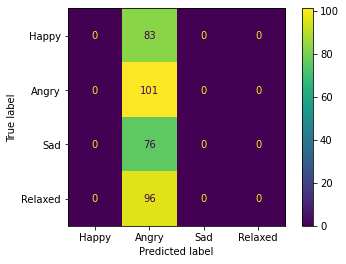

In [ ]:
# Baseline Evaluation of the model
y_pred = dummy_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

#### Where to Go From Here
- From here we'll quickly assess other possible alternative models to see if we can find a better model than the baseline dummy model.

#### Quickly Assessing Possible Alternative Models
- We'll loop through a few different models to see if we can improve on the performance of the first simple model here.

In [ ]:
# Creates variables of commonly used models
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()
mlp_model = MLPClassifier()
svc_model = SVC()

# Creates a list of the models to be used
model_list = [('dummy', dum_model), ('logreg', lr_model), ('dt', tree_model), ('knn', knn_model), ('rf', rf_model), ('ada', ada_model), ('gb', gb_model), ('mlp', mlp_model), ('svc', svc_model)]

In [ ]:
# Creates a Pipeline for each model in the model list, and returns a cross-validated accuracy score summary for each model
for name, model in model_list:
    loop_model_pipe = Pipeline(steps = [
        ('ct',CT),
        (name, model)
    ])

    loop_model_pipe.fit(X_train, y_train)

    loop_model_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    loop_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.28373 ± 0.00818 accuracy
        
CV Results for `logreg` model:
            0.48302 ± 0.06581 accuracy
        
CV Results for `dt` model:
            0.48579 ± 0.08294 accuracy
        
CV Results for `knn` model:
            0.48317 ± 0.05675 accuracy
        
CV Results for `rf` model:
            0.56992 ± 0.07026 accuracy
        
CV Results for `ada` model:
            0.43817 ± 0.09869 accuracy
        
CV Results for `gb` model:
            0.55040 ± 0.04711 accuracy
        


c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jam

CV Results for `mlp` model:
            0.46333 ± 0.06627 accuracy
        
CV Results for `svc` model:
            0.47175 ± 0.08425 accuracy
        


c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Discussion**
- As we can see above, the models that performed the best on our test data were the decision tree, gradient boosting, and random forest models. This is likely because these models are able to capture the non-linear relationships between the audio features and the dominant mood of the song. Below we explicitly create each model and view the accuracy scores and confusion matrices for each model.

##### The Decision Tree Model

In [ ]:
# Creates a Pipeline for the Decision Tree Model
dt_model_pipe = Pipeline(steps = [
	('ct',CT),
	('dt', DecisionTreeClassifier())
])

In [ ]:
# Trains the logistic regression model
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                ('dt', DecisionTreeClassifier())])

In [ ]:
# Returns the mean accuracy score of the model based on the given training data and labels
dt_model_pipe.score(X_train, y_train)

0.9929577464788732

In [ ]:
# Returns the mean accuracy score of the model based on the given testing data and labels
dt_model_pipe.score(X_test, y_test)

0.8314606741573034

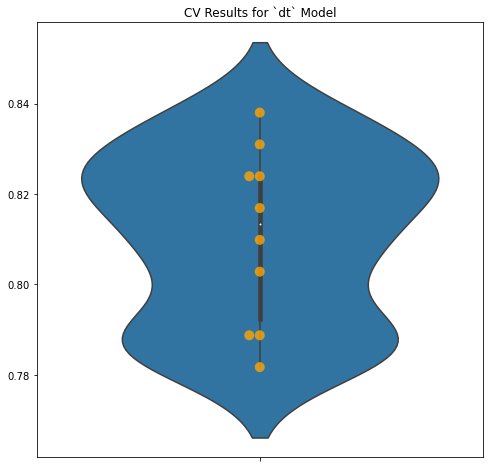

In [ ]:
dt_model_pipe = ModelWithCV(
	dt_model_pipe,
	model_name='dt',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

dt_model_pipe.plot_cv(ax=ax);

Accuracy: 0.8314606741573034
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        83
           1       0.82      0.79      0.80       101
           2       0.84      0.84      0.84        76
           3       0.87      0.86      0.87        96

    accuracy                           0.83       356
   macro avg       0.83      0.83      0.83       356
weighted avg       0.83      0.83      0.83       356



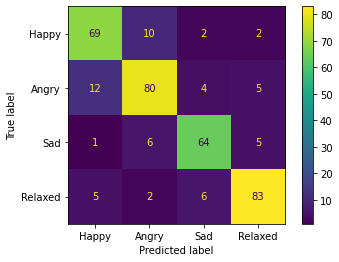

In [ ]:
# Baseline Evaluation of the model
y_pred = dt_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

Discussion:
- Although the decision tree model performed better than the baseline dummy model, it is likely overfitting the data and will require tuning to improve it's performance. We'll tune the model using GridSearchCV to find the optimal hyperparameters for the model IF we decide to use this model.

##### The Gradient Boosting Model

In [ ]:
# Creates a Pipeline for the Decision Tree Model
gb_model_pipe = Pipeline(steps = [
	('ct',CT),
	('gb', GradientBoostingClassifier())
])

In [ ]:
# Trains the logistic regression model
gb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                ('gb', GradientBoostingClassifier())])

In [ ]:
# Returns the mean accuracy score of the model based on the given training data and labels
gb_model_pipe.score(X_train, y_train)

0.8676056338028169

In [ ]:
# Returns the mean accuracy score of the model based on the given testing data and labels
gb_model_pipe.score(X_test, y_test)

0.7359550561797753

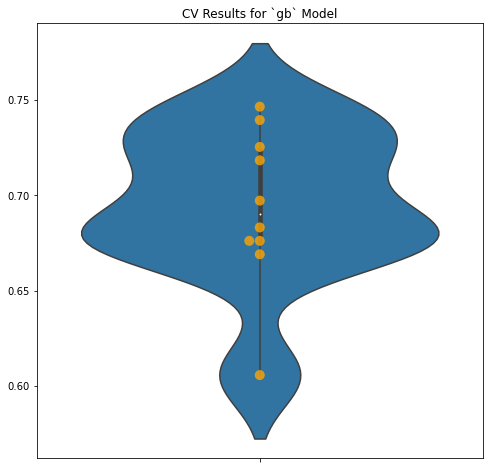

In [ ]:
gb_model_pipe = ModelWithCV(
	gb_model_pipe,
	model_name='gb',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

gb_model_pipe.plot_cv(ax=ax);

Accuracy: 0.7359550561797753
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        83
           1       0.80      0.77      0.79       101
           2       0.68      0.71      0.70        76
           3       0.79      0.76      0.78        96

    accuracy                           0.74       356
   macro avg       0.73      0.73      0.73       356
weighted avg       0.74      0.74      0.74       356



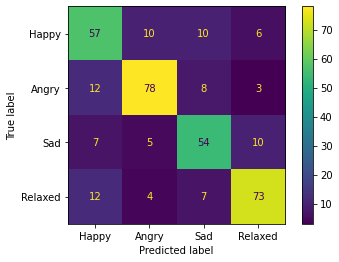

In [ ]:
# Baseline Evaluation of the model
y_pred = gb_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

Discussion:
- The gradient boosting model performed better than the baseline dummy model, but not as well as the decision tree model. We'll tune the model using GridSearchCV to find the optimal hyperparameters for the model IF we decide to use this model.

#### The Random Forest Model

In [ ]:
# Creates a Pipeline for the Decision Tree Model
rf_model_pipe = Pipeline(steps = [
	('ct',CT),
	('rf', RandomForestClassifier())
])

In [ ]:
# Trains the logistic regression model
rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                ('rf', RandomForestClassifier())])

In [ ]:
# Returns the mean accuracy score of the model based on the given training data and labels
rf_model_pipe.score(X_train, y_train)

0.9929577464788732

In [ ]:
# Returns the mean accuracy score of the model based on the given testing data and labels
rf_model_pipe.score(X_test, y_test)

0.8848314606741573

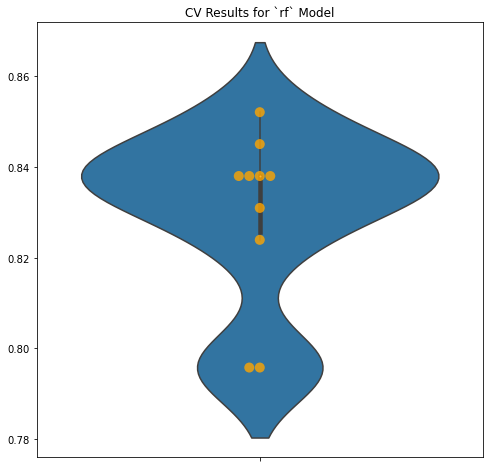

In [ ]:
rf_model_pipe = ModelWithCV(
	rf_model_pipe,
	model_name='rf',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

rf_model_pipe.plot_cv(ax=ax);

Accuracy: 0.8707865168539326
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        83
           1       0.91      0.85      0.88       101
           2       0.87      0.88      0.88        76
           3       0.89      0.90      0.89        96

    accuracy                           0.87       356
   macro avg       0.87      0.87      0.87       356
weighted avg       0.87      0.87      0.87       356



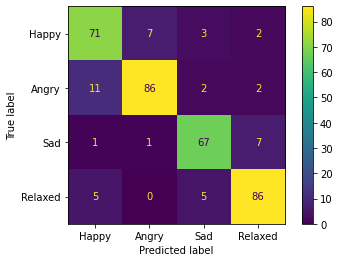

In [ ]:
# Baseline Evaluation of the model
y_pred = rf_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

***Discussion of Comparison of Model Results***
- Comparing the three models against the baseline dummy model, we can see that the random forest model performed the best, followed by the decision tree model, and then the gradiant boost model. Based on these results, we'll move forward with the random forest model and tune it using GridSearchCV to find the optimal hyperparameters for the model.

### Iterating on the Random Forest Model
- We've decided to move forward with the random forest model, and so we'll tune the hyperparameters of the random forest model to improve it's performance.

In [ ]:
# For Reference: The Random Forest Model
rf_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                ('rf', RandomForestClassifier())])

Because the ColumnTransformer is a pipeline, we can use it in a GridSearchCV object to find the best hyperparameters for our model.

Because we're using a random forest model, we'll need to tune the hyperparameters of the model to improve it's performance. We'll use a grid search to tune the hyperparameters of the model.

In [ ]:
# Creates a list of parameters to be used in the GridSearchCV. Due to the large number of parameters, and cpu and time constraints, only a few are used here. The rest are commented out for convenience.
params = {}

params['rf__n_estimators'] = [100, 200, 300, 400, 500]
params['rf__criterion'] = ['gini', 'entropy','log_loss']
params['rf__max_depth'] = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# params['rf__min_samples_split'] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# params['rf__min_samples_leaf'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# params['rf__min_weight_fraction_leaf'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# params['rf__max_features'] = ['auto', 'sqrt', 'log2']
# params['rf__max_leaf_nodes'] = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# params['rf__min_impurity_decrease'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# params['rf__bootstrap'] = [True, False]
# params['rf__oob_score'] = [True, False]
# params['rf__n_jobs'] = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# params['rf__random_state'] = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# params['rf__verbose'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# params['rf__warm_start'] = [True, False]
# params['rf__class_weight'] = ['balanced', 'balanced_subsample', None]
# params['rf__ccp_alpha'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# params['rf__max_samples'] = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
gs = GridSearchCV(estimator=rf_model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)

In [ ]:
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'rf__n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

In [ ]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   17.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F10E5490>)])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'rf__n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

In [ ]:
gs.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__n_estimators': 100}

In [ ]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000238F3556C10>)])),
                ('rf', RandomForestClassifier())])

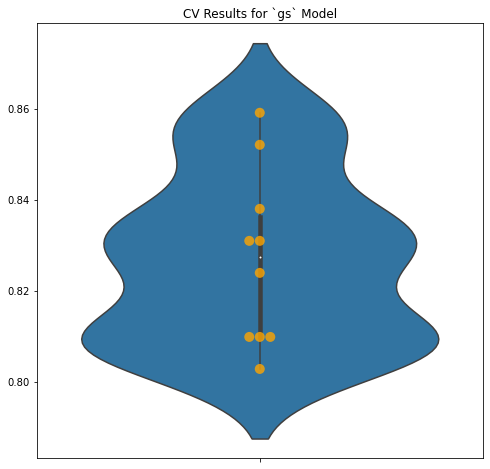

In [ ]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(8,8))

gs_pipe.plot_cv(ax=ax);

Accuracy: 0.8932584269662921
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        83
           1       0.93      0.90      0.91       101
           2       0.91      0.91      0.91        76
           3       0.90      0.89      0.89        96

    accuracy                           0.89       356
   macro avg       0.89      0.89      0.89       356
weighted avg       0.89      0.89      0.89       356



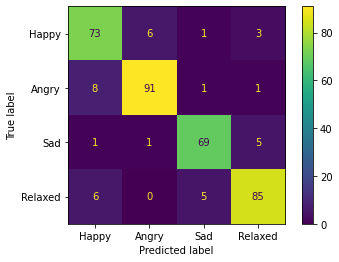

In [ ]:
# Tuned Evaluation of the model
y_pred = gs_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

### Evaluation

The baseline dummy model had an accuracy score of 0.25, meaning that the model correctly predicted the dominant mood of a song only 25% of the time. The baseline random forest model had an accuracy score of 0.88, meaning that the model correctly predicted the dominant mood of a song 88% of the time. Because the baseline random forest model performed better than any of the other models, the author moved forward with the random forest model. After tuning the hyperparameters of the random forest model further, an accuracy score of 0.89 was achieved, meaning that the model correctly predicted the dominant mood of a song 89% of the time. Finally, to simulate the model's performance against real world data, we have the holdout set:

### Evaluating the Model on the Holdout Set

In [ ]:
# Returns the mean accuracy score of the model based on the given training data and labels
gs.score(X_train, y_train)

0.9929577464788732

In [ ]:
# Returns the mean accuracy score of the model based on the holdout data
gs.score(X_holdout, y_holdout)

0.9860834990059643

## Recommendation System

### Content-Based Model using Cosine Similarity

In [87]:
# Drops the title, artist_id, artist_name, and release columns from the dataframe
merged_df.drop(columns=['title', 'artist_id', 'artist_name', 'release'], inplace=True)


In [88]:
merged_df

,mode,time_signature,tempo,loudness,Lazy Afternoon En Anglais,#8,&Like A Bolt Of Lightning,'60s Pop Number 1's,'77 In '97,(ONe),...,xmas,xmasparty,ye-ye,yeah,yes,yes no maybe,yessss,you,zouk,zydeco
TRAAAAW128F429D538,0.0,4.0,92.198,-11.197,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAABD128F429CF47,0.0,4.0,121.274,-9.843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAADZ128F9348C2E,1.0,1.0,100.070,-9.689,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAEF128F4273421,1.0,4.0,119.293,-9.013,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRAAAFD128F92F423A,1.0,4.0,129.738,-4.501,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBIJMU12903CF892B,1.0,4.0,140.185,-8.087,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNF128F14815A7,1.0,3.0,77.072,-14.517,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJNK128F93093EC,1.0,4.0,118.123,-12.087,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRBIJRN128F425F3DD,1.0,4.0,137.663,-12.574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
# Creates a function to compute the similarity matrix
def compute_similarity_matrix(df):
    # Scales the features
    scaler = StandardScaler()
    # Computes the cosine similarity matrix
    df_scaled = scaler.fit_transform(df)
    # Computes the cosine similarity matrix
    cosine_sim = cosine_similarity(df_scaled)
    # Converts the cosine similarity matrix to a dataframe
    similarity_matrix = pd.DataFrame(cosine_sim, index=df.index, columns=df.index)
    # Returns the similarity matrix
    return similarity_matrix

In [92]:
# Computes the similarity matrix
similarity_matrix = compute_similarity_matrix(df=merged_df)
# Displays the similarity matrix
similarity_matrix.head()

,TRAAAAW128F429D538,TRAAABD128F429CF47,TRAAADZ128F9348C2E,TRAAAEF128F4273421,TRAAAFD128F92F423A,TRAAAMO128F1481E7F,TRAAAMQ128F1460CD3,TRAAAPK128E0786D96,TRAAARJ128F9320760,TRAAAVG12903CFA543,...,TRBIJFO128F42990C5,TRBIJIA128F425F57D,TRBIJIP128F9334953,TRBIJKN12903CBF11B,TRBIJLT12903CE7070,TRBIJMU12903CF892B,TRBIJNF128F14815A7,TRBIJNK128F93093EC,TRBIJRN128F425F3DD,TRBIJYB128F14AE326
TRAAAAW128F429D538,1.000000,-0.000414,-0.000112,-0.000274,-0.000160,-0.000138,-0.000101,0.000105,-0.000163,0.000097,...,-0.000097,-0.000258,-0.000030,-0.000086,-0.000404,-0.000612,-0.000110,-0.000048,-0.000119,-0.000318
TRAAABD128F429CF47,-0.000414,1.000000,-0.000731,-0.000971,-0.000732,-0.000951,-0.000992,-0.000526,-0.000711,-0.000510,...,-0.000664,-0.000520,-0.000927,-0.001144,-0.000626,-0.000403,-0.000818,-0.000661,-0.000557,-0.000315
TRAAADZ128F9348C2E,-0.000112,-0.000731,1.000000,0.000555,0.000671,0.001443,0.001991,0.000952,0.000452,0.000770,...,0.000814,-0.000146,0.001367,0.001557,-0.000386,-0.001134,0.000999,0.000902,0.000481,-0.000513
TRAAAEF128F4273421,-0.000274,-0.000971,0.000555,1.000000,0.000545,0.001042,0.000897,0.000561,0.000230,0.000619,...,0.000745,-0.000282,0.001129,0.001325,-0.000813,-0.001387,0.000518,0.000765,0.000375,-0.000678
TRAAAFD128F92F423A,-0.000160,-0.000732,0.000671,0.000545,1.000000,0.001239,0.000886,0.000648,0.000303,0.000790,...,0.000841,-0.000170,0.001270,0.001446,-0.000658,-0.001107,0.000550,0.000828,0.000457,-0.000454


Generating Recommendations:
Here we show an example of how the content-based recommendation system works. We will use the song_id SOMZWCG12A8C13C480, "I'm On My Way" by The Proclaimers, as an example.

In [97]:
# Creates a function that returns the top 10 song recommendations for a given Track ID
def get_song_recommendations(track_id):
    # Sorts the songs based on similarity to the target in descending order and returns the top 10
    top_10_most_similar_songs = similarity_matrix[track_id].sort_values(ascending=False)[1:11]
    # Returns the song titles and artist names of the top 10 songs
    top_10_song_recommendations = msd_df.loc[top_10_most_similar_songs.index]
    return top_10_song_recommendations[['title', 'artist_name']]

# Uses the function to get the top 10 song recommendations for the song with Track ID TRAAAAW128F429D538
get_song_recommendations('TRAAAAW128F429D538')

,title,artist_name
TRBFRNE128F42368B1,Kick_ Push II (Album Version),Lupe Fiasco
TRBHYBJ128C7196D75,I Know You Got Soul,Eric B. & Rakim
TRAYFKN128F148C55A,Intro,Erick Sermon
TRAUEVU128F42B7B0A,Jane 5,EPMD
TRBFBOG128F9356C6E,Head Banger,EPMD
TRAWVLS128F148D430,Give The People,EPMD
TRAEBSY128E07873C0,Mistadobalina,Del Tha Funkee Homosapien
TRAWEIX128F14B0F05,They Reminisce Over You (Single Version),Pete Rock & C.L. Smooth
TRANDHE128F9305CDA,Run's House,RUN-DMC
TRABDTV128E0791839,Mayday,Natural Elements


### Integrating Mood Detection

The primary goal of the project was to accomplish two things:
1) Build a recommendation system that can generate recommendations based on a song's audio features
2) Curate the recommendations based on the mood of the user

In the following section, we will show how we integrated mood detection into our recommendation system. We will use the song_id SOMZWCG12A8C13C480, "I'm On My Way" by The Proclaimers, as an example.

### Collaborative Filtering

### Aleternating Least-Squares (ALS)

## Conclusion:

- Content based systems are simple to implement but hard to measure error (no RMSE)
- Collaborative filtering has issues with cold start (movies with no ratings)
- Collaborative filtering using surprise is incredibly effective and produces great models
- ALS is incredibly efficient an simple

There are many options to create recommendation systems. 
In this notebook we explored content based systems using cosign similarity, 
various collaborative filtering models via surprise,
and dove deep into the concepts behind ALS to explain how it works.

We were able to beat BellKor’s Pragmatic Chaos's RMSE of 0.8567 with an RMSE of 0.8559 but this was likely because of our smaller dataset.

The best approach to recommendation systems is likely a hybrid approach which we will not explore in this notebook.